In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving emotions_dataset.parquet to emotions_dataset (1).parquet
User uploaded file "emotions_dataset (1).parquet" with length 7410542 bytes


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, RepeatVector, TimeDistributed
import numpy as np
import pandas as pd

In [ ]:
# training set
df = pd.read_parquet("/content/emotions_dataset.parquet")
df.head(100)

,Sentence,Label
0,Unfortunately later died from eating tainted m...,happiness
1,Last time I saw was loooong ago. Basically bef...,neutral
2,You mean by number of military personnel? Beca...,neutral
3,Need to go middle of the road no NAME is going...,sadness
4,feel melty miserable enough imagine must,sadness
...,...,...
95,My heart is a tapestry of silent loss.,sadness
96,my roommate got married and invited me to shar...,guilt
97,The hardest part is trying to figure out what ...,sadness
98,If you buy a membership for yourself and your ...,neutral


In [ ]:
# filter out only the records that have emotions from a list
emotions = ['anger', 'happiness', 'disgust', 'fear', 'neutral', 'sadness', 'surprise']
df = df[df['Label'].isin(emotions)]
df.head(20)

,Sentence,Label
0,Unfortunately later died from eating tainted m...,happiness
1,Last time I saw was loooong ago. Basically bef...,neutral
2,You mean by number of military personnel? Beca...,neutral
3,Need to go middle of the road no NAME is going...,sadness
4,feel melty miserable enough imagine must,sadness
5,feel sense relief also sadness end colleagues ...,happiness
6,think get feel weird ones use dryers time,surprise
7,If your host stand has a register that isn’t l...,neutral
8,Oh . someone finally posted something I cant b...,surprise
10,"Did I ? Well . Anyway , youll get your raise w...",neutral


In [ ]:
emotion_mapping = {
    'sadness': 'sad',
    'anger': 'angry',
    'happiness': 'happy',
}

df['Label'] = df['Label'].replace(emotion_mapping)
display(df.head(100))

,Sentence,Label
0,Unfortunately later died from eating tainted m...,happy
1,Last time I saw was loooong ago. Basically bef...,neutral
2,You mean by number of military personnel? Beca...,neutral
3,Need to go middle of the road no NAME is going...,sad
4,feel melty miserable enough imagine must,sad
...,...,...
124,i feel little impatient especially thinking of...,angry
125,I’m so pleased the app’s updates are so seamless!,happy
126,This is the last straw for me!,angry
127,know affect importance beauty embed deeply thi...,sad


In [ ]:
texts = df['Sentence'].tolist()
labels = df['Label'].tolist()

Max length: 820
Min length: 20
Average length: 78.39687531296946


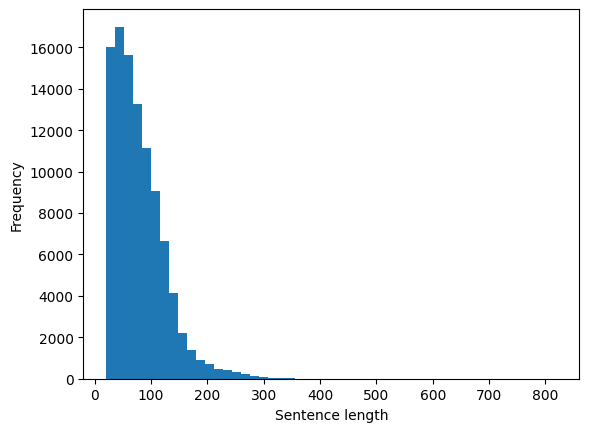

In [ ]:
import matplotlib.pyplot as plt

# Get sentence lengths
sentence_lengths = [len(seq) for seq in texts]

# Basic stats
print("Max length:", max(sentence_lengths))
print("Min length:", min(sentence_lengths))
print("Average length:", sum(sentence_lengths)/len(sentence_lengths))

# Plot histogram
plt.hist(sentence_lengths, bins=50)
plt.xlabel("Sentence length")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import re
from typing import Iterable, List, Set, Optional

def make_tokenizer(
    keep_punct: Set[str] = {"!", "?"},
    remove_punct_in_output: bool = True,
    stop_words: Optional[Set[str]] = None,
):
    """
    Returns a tokenizer function:
      - lowercases
      - extracts words (with optional apostrophes) + selected punctuation (e.g., ! ?)
      - optionally removes punctuation tokens from output
      - optionally removes stopwords
    """
    kept = "".join(sorted(keep_punct))
    # words like don't, can't are kept as single tokens; also keep ! and ? as tokens
    pattern = re.compile(r"[a-z]+(?:'[a-z]+)?|[" + re.escape(kept) + r"]")

    def tokenize(text: str) -> List[str]:
        text = text.lower()
        tokens = pattern.findall(text)
        if remove_punct_in_output:
            tokens = [t for t in tokens if t not in keep_punct]
        if stop_words:
            tokens = [t for t in tokens if t not in stop_words]
        return tokens

    return tokenize


In [ ]:
tokenize_train = make_tokenizer(keep_punct={"!", "?"}, remove_punct_in_output=True, stop_words=None)

tokenized_texts = [tokenize_train(t) for t in texts]
tokenized_texts[:10]

[['unfortunately',
  'later',
  'died',
  'from',
  'eating',
  'tainted',
  'meat',
  'name',
  'bbc',
  'documentary',
  'dynasties',
  'followed',
  'the',
  'marsh',
  'pride',
  'the',
  'lion',
  'episode',
  'was',
  'awesome'],
 ['last',
  'time',
  'i',
  'saw',
  'was',
  'loooong',
  'ago',
  'basically',
  'before',
  'ln',
  'announced',
  'they',
  'went',
  'for',
  'probabilistic',
  'routing'],
 ['you',
  'mean',
  'by',
  'number',
  'of',
  'military',
  'personnel',
  'because',
  'if',
  'you',
  'go',
  'by',
  'navy',
  'size',
  'or',
  'budget',
  'thats',
  'not',
  'even',
  'remotely',
  'true'],
 ['need',
  'to',
  'go',
  'middle',
  'of',
  'the',
  'road',
  'no',
  'name',
  'is',
  'going',
  'to',
  'vote',
  'for',
  'name'],
 ['feel', 'melty', 'miserable', 'enough', 'imagine', 'must'],
 ['feel',
  'sense',
  'relief',
  'also',
  'sadness',
  'end',
  'colleagues',
  'anyway',
  'fab'],
 ['think', 'get', 'feel', 'weird', 'ones', 'use', 'dryers', 'ti

In [ ]:
from collections import Counter

PAD, UNK = "<PAD>", "<UNK>"

def build_vocab(tokenized_texts, min_freq=2, max_size=30000, specials=(PAD, UNK)):
    # 1. Count all words
    counter = Counter(tok for seq in tokenized_texts for tok in seq)

    # 2. Drop words that appear less than min_freq times
    items = [(tok, freq) for tok, freq in counter.items() if freq >= min_freq]

    # 3. Sort: first by frequency (descending), then alphabetically for stability
    items.sort(key=lambda x: (-x[1], x[0]))

    # 4. Start vocab with special tokens
    vocab = {specials[0]: 0, specials[1]: 1}

    # 5. Add up to max_size most frequent words
    for tok, _ in items[: max_size - len(specials)]:
        vocab[tok] = len(vocab)

    # 6. Build reverse mapping (id -> word)
    ivocab = {i: t for t, i in vocab.items()}

    return vocab, ivocab, counter

In [ ]:
vocab, ivocab, freq_counter = build_vocab(tokenized_texts, min_freq=2, max_size=30000)
vocab

{'<PAD>': 0,
 '<UNK>': 1,
 'i': 2,
 'the': 3,
 'to': 4,
 'a': 5,
 'feel': 6,
 'and': 7,
 'of': 8,
 'that': 9,
 'it': 10,
 'you': 11,
 'my': 12,
 'is': 13,
 'in': 14,
 'this': 15,
 'for': 16,
 'like': 17,
 'was': 18,
 'me': 19,
 'with': 20,
 'so': 21,
 's': 22,
 'but': 23,
 'have': 24,
 'not': 25,
 'on': 26,
 'be': 27,
 'feeling': 28,
 'just': 29,
 't': 30,
 'are': 31,
 'at': 32,
 'when': 33,
 'as': 34,
 'they': 35,
 'he': 36,
 'about': 37,
 'm': 38,
 'im': 39,
 'get': 40,
 'all': 41,
 'can': 42,
 'if': 43,
 'people': 44,
 'what': 45,
 'really': 46,
 'one': 47,
 'your': 48,
 'know': 49,
 'time': 50,
 'an': 51,
 'would': 52,
 'do': 53,
 'we': 54,
 'am': 55,
 'name': 56,
 'out': 57,
 'think': 58,
 'up': 59,
 'or': 60,
 'had': 61,
 'from': 62,
 'because': 63,
 'more': 64,
 'no': 65,
 'how': 66,
 'its': 67,
 'by': 68,
 'will': 69,
 'make': 70,
 'her': 71,
 'she': 72,
 'now': 73,
 'there': 74,
 'good': 75,
 'them': 76,
 'want': 77,
 'even': 78,
 'still': 79,
 'been': 80,
 'him': 81,
 'very':

In [ ]:
def build_label_map(labels: List[str]):
    classes = sorted(set(labels))
    label2id = {c: i for i, c in enumerate(classes)}
    id2label = {i: c for c, i in label2id.items()}
    y = [label2id[l] for l in labels]
    return y, label2id, id2label

In [ ]:
y, label2id, id2label = build_label_map(labels)

In [ ]:
from collections import defaultdict
import string

# 1) Prepare a stopword set (use your own list if you have one)
basic_stop = {
    "the","a","an","and","or","but","if","then","so","for","to","of","in","on","at","is","am","are","be","was","were",
    "this","that","it","as","with","by","from","not","no","do","does","did","have","has","had","i","you","he","she","we","they"
}
punct = set(string.punctuation)

In [ ]:
def sentence_to_keywords(tokens, keep_max=6):
    # drop stopwords, punctuation, very short tokens, and keep unique order
    seen = set()
    kw = []
    for t in tokens:
        if t in punct: continue
        if len(t) < 3: continue
        if t in basic_stop: continue
        if t not in seen:
            seen.add(t)
            kw.append(t)
        if len(kw) >= keep_max:
            break
    return kw

In [ ]:
# Example: create decoder target strings (per row)
decoder_targets_tokens = [sentence_to_keywords(tokens) for tokens in tokenized_texts]
decoder_targets_tokens[:10]

[['unfortunately', 'later', 'died', 'eating', 'tainted', 'meat'],
 ['last', 'time', 'saw', 'loooong', 'ago', 'basically'],
 ['mean', 'number', 'military', 'personnel', 'because', 'navy'],
 ['need', 'middle', 'road', 'name', 'going', 'vote'],
 ['feel', 'melty', 'miserable', 'enough', 'imagine', 'must'],
 ['feel', 'sense', 'relief', 'also', 'sadness', 'end'],
 ['think', 'get', 'feel', 'weird', 'ones', 'use'],
 ['your', 'host', 'stand', 'register', 'isn', 'locked'],
 ['someone', 'finally', 'posted', 'something', 'cant', 'bring'],
 ['well', 'anyway', 'youll', 'get', 'your', 'raise']]

In [ ]:
# Filter out rows that ended up with empty keyword lists
valid_idx = [i for i, kw in enumerate(decoder_targets_tokens) if len(kw) > 0]
decoder_targets_tokens = [decoder_targets_tokens[i] for i in valid_idx]
emotion_labels = [df['Label'].iloc[i] for i in valid_idx]

In [ ]:
SOS, EOS = "<SOS>", "<EOS>"

for special in (SOS, EOS):
    if special not in vocab:
        vocab[special] = len(vocab)
        ivocab[vocab[special]] = special

PAD_ID = vocab["<PAD>"]    # should be 0 from your setup
UNK_ID = vocab["<UNK>"]
SOS_ID = vocab[SOS]
EOS_ID = vocab[EOS]
vocab_size = len(vocab)

In [ ]:
emotions = sorted(set(emotion_labels))
emo2id = {e:i for i,e in enumerate(emotions)}
id2emo = {i:e for e,i in emo2id.items()}
num_emotions = len(emo2id)

encoder_inputs = [emo2id[e] for e in emotion_labels]   # shape: (N,)

In [ ]:
def encode_keywords_to_ids(words, vocab, max_len):
    ids = [vocab.get(w, UNK_ID) for w in words]
    # add SOS/EOS
    in_ids  = [SOS_ID] + ids
    out_ids = ids + [EOS_ID]
    # pad/truncate
    in_ids  = (in_ids + [PAD_ID]*max(0, max_len - len(in_ids)))[:max_len]
    out_ids = (out_ids + [PAD_ID]*max(0, max_len - len(out_ids)))[:max_len]
    return in_ids, out_ids

# Choose a target max length (short; keywords only). You can also use a percentile on lengths.
tgt_lengths = [len(kw) for kw in decoder_targets_tokens]
MAX_TGT_LEN = min(12, max(3, int(np.percentile(tgt_lengths, 95)) + 2))  # +2 for SOS/EOS, cap at ~12

decoder_in, decoder_out = [], []
for kw in decoder_targets_tokens:
    di, do = encode_keywords_to_ids(kw, vocab, MAX_TGT_LEN)
    decoder_in.append(di)
    decoder_out.append(do)

encoder_in = np.array(encoder_inputs, dtype=np.int32)                 # (N,)
decoder_in = np.array(decoder_in, dtype=np.int32)                     # (N, T_out)
decoder_out = np.array(decoder_out, dtype=np.int32)                   # (N, T_out)

In [ ]:
from sklearn.model_selection import train_test_split  # if not already imported

E_train, E_test, Din_train, Din_test, Dout_train, Dout_test = train_test_split(
    encoder_in, decoder_in, decoder_out, test_size=0.2, random_state=42, stratify=encoder_in
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Hyperparams
EMO_EMBED   = 16         # small embedding for emotions
WORD_EMBED  = 128        # your word embedding size
DEC_HIDDEN  = 256        # decoder LSTM hidden size
TGT_MAXLEN  = MAX_TGT_LEN

In [ ]:
# Inputs
enc_inp = layers.Input(shape=(), dtype='int32', name='emotion_id')              # scalar per sample
dec_inp = layers.Input(shape=(TGT_MAXLEN,), dtype='int32', name='decoder_in')   # <SOS> ... padded

In [ ]:
# Emotion encoder → initial states
emo_emb = layers.Embedding(input_dim=num_emotions, output_dim=EMO_EMBED, name='emo_embedding')(enc_inp)
# project to h0, c0
h0 = layers.Dense(DEC_HIDDEN, activation='tanh', name='h0')(emo_emb)
c0 = layers.Dense(DEC_HIDDEN, activation='tanh', name='c0')(emo_emb)

In [ ]:
# Decoder
dec_emb = layers.Embedding(input_dim=vocab_size, output_dim=WORD_EMBED, mask_zero=True, name='word_embedding')(dec_inp)
dec_out = layers.LSTM(DEC_HIDDEN, return_sequences=True, name='decoder_lstm')(dec_emb, initial_state=[h0, c0])
logits  = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'), name='softmax')(dec_out)

In [ ]:
model = Model(inputs=[enc_inp, dec_inp], outputs=logits)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')  # targets are integer ids
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emotion_id          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_in          │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emo_embedding       │ (None, 16)        │        112 │ emotion_id[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ word_embedding      │ (None, 8, 128)    │  3,185,920 │ decoder_in[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h0 (Dense)          │ (None, 256)       │      4,352 │ emo_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c0 (Dense)          │ (None, 256)       │      4,352 │ emo_embedding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ (None, 8, 256)    │    394,240 │ word_embedding[0… │
│                     │                   │            │ h0[0][0],         │
│                     │                   │            │ c0[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 8)         │          0 │ decoder_in[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax             │ (None, 8, 24890)  │  6,396,730 │ decoder_lstm[0][… │
│ (TimeDistributed)   │                   │            │ not_equal_1[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,985,706 (38.09 MB)

 Trainable params: 9,985,706 (38.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Dout_train_sparse = np.expand_dims(Dout_train, -1)
Dout_test_sparse  = np.expand_dims(Dout_test, -1)

history = model.fit(
    [E_train, Din_train], Dout_train_sparse,
    validation_data=([E_test, Din_test], Dout_test_sparse),
    batch_size=64,
    epochs=10
)

Epoch 1/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 7.0045 - val_loss: 6.3145
Epoch 2/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - loss: 6.1468 - val_loss: 6.0667
Epoch 3/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - loss: 5.8068 - val_loss: 5.9327
Epoch 4/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - loss: 5.5377 - val_loss: 5.8641
Epoch 5/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - loss: 5.2984 - val_loss: 5.8121
Epoch 6/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 5.0705 - val_loss: 5.7769
Epoch 7/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - loss: 4.8652 - val_loss: 5.7530
Epoch 8/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - loss: 4.6551 - val_loss: 5.7365
Epoch 9/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - loss: 4.4847 - val_loss: 5.7250
Epoch 10/10
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - loss: 4.3200 - val_loss: 5.7212


In [ ]:
import numpy as np

def sample_next(probs, top_k=5, temperature=1.0):
    # apply temperature
    probs = np.log(probs + 1e-8) / temperature
    probs = np.exp(probs) / np.sum(np.exp(probs))
    # restrict to top_k
    top_indices = np.argsort(probs)[-top_k:]
    top_probs = probs[top_indices]
    top_probs = top_probs / np.sum(top_probs)
    return np.random.choice(top_indices, p=top_probs)

In [ ]:
def generate_keywords(emotion_label, max_len=TGT_MAXLEN, top_k=1):
    e_id = np.array([emo2id[emotion_label]], dtype=np.int32)
    dec_seq = np.full((1, max_len), PAD_ID, dtype=np.int32)
    dec_seq[0,0] = SOS_ID

    # we’ll feed teacher-forcing style inputs but replace positions as we generate
    for t in range(1, max_len):
        probs = model.predict([e_id, dec_seq], verbose=0)[0, t-1]  # distribution for next token
        next_id = int(sample_next(probs))  # greedy; or sample/top-k
        dec_seq[0,t] = next_id
        if next_id == EOS_ID:
            break

    # convert to tokens (skip SOS/EOS/PAD)
    ids = dec_seq[0,1:t] if dec_seq[0,t]==EOS_ID else dec_seq[0,1:]
    toks = [ivocab.get(i, "<UNK>") for i in ids if i not in (PAD_ID, SOS_ID, EOS_ID)]
    # dedup but keep order
    seen, out = set(), []
    for tok in toks:
        if tok not in seen:
            seen.add(tok)
            out.append(tok)
    return out

# Example:
print(generate_keywords("happy"))
print(generate_keywords("sad"))
print(generate_keywords("angry"))

['feel', 'like', 'should', 'something', 'worthwhile', 'box']
['feel', 'pretty', 'ungrateful', 'right', 'now']
['don', 'feel', 'irritated', 'think']


In [ ]:
def beam_search_generate(emotion_label, beam_width=3, max_len=TGT_MAXLEN):
    e_id = np.array([emo2id[emotion_label]], dtype=np.int32)

    # Beam entries: (sequence so far, score)
    beam = [( [SOS_ID], 0.0 )]  # start with SOS

    results = []

    for _ in range(max_len):
        new_beam = []
        for seq, score in beam:
            dec_seq = np.full((1, max_len), PAD_ID, dtype=np.int32)
            dec_seq[0,:len(seq)] = seq

            # Predict probs for next step
            probs = model.predict([e_id, dec_seq], verbose=0)[0, len(seq)-1]

            # Get top-k candidates
            top_ids = np.argsort(probs)[-beam_width:]

            for tok_id in top_ids:
                new_seq = seq + [tok_id]
                new_score = score - np.log(probs[tok_id] + 1e-9)

                if tok_id == EOS_ID:
                    results.append((new_seq, new_score))
                else:
                    new_beam.append((new_seq, new_score))

        # Keep only best beams
        beam = sorted(new_beam, key=lambda x: x[1])[:beam_width]

    # Add remaining unfinished sequences
    results.extend(beam)

    # Sort final results
    results = sorted(results, key=lambda x: x[1])

    # Convert IDs to tokens
    decoded_sequences = []
    for seq, score in results:
        toks = [ivocab.get(i, "<UNK>") for i in seq if i not in (PAD_ID, SOS_ID, EOS_ID)]
        decoded_sequences.append((" ".join(toks), score))

    return decoded_sequences


In [ ]:
print("Beam search for 'happy':")
print(beam_search_generate("happy", beam_width=5))

print("Beam search for 'sad':")
print(beam_search_generate("sad", beam_width=5))


Beam search for 'happy':
[('feel like something productive', np.float32(11.395566)), ('feel like being sociable', np.float32(11.627729)), ('feel like being sociable just aaaah', np.float32(11.672541)), ('feel like ive been feeling bit', np.float32(14.056989)), ('feel like ive been feeling more', np.float32(14.309178)), ('feel like ive been feeling very', np.float32(14.589628)), ('feel like should supermarket get something', np.float32(14.834353)), ('feel like should supermarket something', np.float32(16.062841)), ('feel like being sociable just', np.float32(17.489384)), ('feel like ive been feeling bit more', np.float32(19.378937)), ('feel like ive been feeling very distracted', np.float32(20.322063)), ('feel like ive been feeling very casual', np.float32(20.414007)), ('feel like ive been feeling very more', np.float32(20.460794)), ('feel like ive been feeling more about', np.float32(20.4619)), ('feel like ive been feeling bit more more', np.float32(27.884401)), ('feel like ive been fe